<a href="https://colab.research.google.com/github/hariharan2302/RL-Project/blob/main/roopeshv_edhanich_hvenkatr_dqn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import torch, random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import roopeshv_edhanich_hvenkatr_Environment_Sim as envi


In [ ]:

def plotRewardVsEpisode(rewards):
    plt.figure(figsize=(8, 6))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Total Reward Per Episode ')
    plt.grid(True)
    plt.show()

tensor([ 8.,  5.,  0.,  0.,  5.,  9.,  7.,  9.,  0.,  0.,  3.,  7.,  8.,  3.,
         0.,  0.,  5.,  6.,  2.,  7.,  0.,  0.,  9.,  4.,  5.,  0.,  0.,  0.,
         5., 10.])
-----------------------------------> n_episode : 0 , 1 , 0
-----------------------------------> n_episode : 1 , 1.0 , -946.2747565596877


/var/folders/y_/m0sk40554hs8lnz0z5m6qk040000gn/T/ipykernel_14214/637099066.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priority_tree[tree_index] = priority
/var/folders/y_/m0sk40554hs8lnz0z5m6qk040000gn/T/ipykernel_14214/637099066.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priority_tree[tree_index] += error


-----------------------------------> n_episode : 2 , 0.999000499833375 , -949.3288979908605
-----------------------------------> n_episode : 3 , 0.9980019986673331 , -895.3254373242496
-----------------------------------> n_episode : 4 , 0.997004495503373 , -965.2507542489153
-----------------------------------> n_episode : 5 , 0.9960079893439915 , -938.9027810347617
-----------------------------------> n_episode : 6 , 0.9950124791926823 , -998.8681198746626
-----------------------------------> n_episode : 7 , 0.9940179640539353 , -668.5745589579059
-----------------------------------> n_episode : 8 , 0.9930244429332351 , -921.6275185979106
-----------------------------------> n_episode : 9 , 0.9920319148370607 , -945.8621230392363
-----------------------------------> n_episode : 10 , 0.9910403787728836 , -535.6094813102527
-----------------------------------> n_episode : 11 , 0.9900498337491681 , -980.9033025468499
-----------------------------------> n_episode : 12 , 0.98906027877536

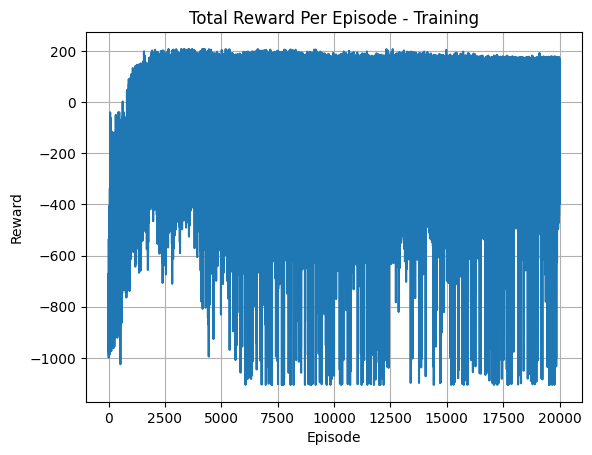

In [ ]:


def sample_best_action(q_network, state, num_samples=5):
    actions = [env.action_space.sample() for _ in range(num_samples)]  # Sample multiple actions randomly
    q_values = [q_network.predict(state, action) for action in actions]  # Predict Q-values for each action
    best_action = actions[np.argmax(q_values)]  # Select the action with the highest Q-value
    return best_action

class SumTree:
    def __init__(self, size):
        self.size = size
        self.priority_tree = np.zeros(2 * size - 1)
        self.data = np.zeros(size, dtype=object)
        self.data_pointer = 0

    def add(self, priority, data):
        tree_index = self.data_pointer + self.size - 1
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)
        self.data_pointer += 1
        if self.data_pointer < self.size-1:
            self.data_pointer += 1
        else :
            self.data_pointer = 0


    def update(self, tree_index, priority):
        error = priority - self.priority_tree[tree_index]
        self.priority_tree[tree_index] = priority

        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.priority_tree[tree_index] += error

    def getExperience(self, value):
        parent_index = 0
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            if left_child_index >= len(self.priority_tree):
                tree_index = parent_index
                break
            else:
                if value <= self.priority_tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    value -= self.priority_tree[left_child_index]
                    parent_index = right_child_index

        data_idx = tree_index - self.size + 1
        return tree_index, self.priority_tree[tree_index], self.data[data_idx]

    def total_priority(self):
        return self.priority_tree[0]

class PrioritizedReplayBuffer():
    def __init__(self, size, bais=0.6):
        self.size = size
        self.bais = bais
        self.tree = SumTree(size)
        self.max_priority = 1.0
        self.e = 0

    def add(self, error, experience):
        priority = (np.abs(error) + 1e-5) ** self.bais
        self.tree.add(priority, experience)
        self.max_priority = max(self.max_priority, priority)
        self.e = experience

    def sample(self, batch_size, beta=0.4):
        batch = []
        indices = []
        priorities = []
        segment = self.tree.total_priority() / batch_size

        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            value = np.random.uniform(a, b)
            (index, priority, experience) = self.tree.getExperience(value)
            if experience == 0:
                experience = self.e
            priorities.append(priority)
            batch.append(experience)
            indices.append(index)

        sampling_probabilities = priorities / self.tree.total_priority()
        sampling_probabilities += 1e-10
        is_weight = np.power(self.tree.data_pointer * sampling_probabilities, -beta)
        is_weight /= is_weight.max()
        return batch, indices, is_weight

    def update_priorities(self, indices, errors):
        for i, error in zip(indices, errors):
            priority = (np.abs(error) + 1e-5) ** self.bais
            self.tree.update(i, priority)
            self.max_priority = max(self.max_priority, priority)

    def __len__(self):
        return self.tree.data_pointer

class Net(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_observations, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DQN():
    def __init__(self, n_observations, n_actions, enable_per):
        self.policy_net = Net(n_observations, n_actions)
        self.target_net = Net(n_observations, n_actions)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.enable_per = enable_per
        if enable_per:
            self.p_replay_memory = PrioritizedReplayBuffer(10000)
        else:
            self.replay_memory = deque([], maxlen=10000)

        self.BATCH_SIZE = 32
        self.env_name = ""
        self.GAMMA = 0.99
        self.TAU = 0.005
        self.LR = 1e-3
        self.E_DECAY = 0.001
        self.epsilon = 1
        self.update_freq = 5
        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.LR, amsgrad=True)

        self.rewards = []
        self.epsilon_values = []
        self.eval_rewards = []

    def learn(self):

        if self.enable_per and len(self.p_replay_memory) < self.BATCH_SIZE:
            return
        elif not self.enable_per and len(self.replay_memory) < self.BATCH_SIZE:
            return

        if self.enable_per:
            batch, indices, weights = self.p_replay_memory.sample(self.BATCH_SIZE)
        else:
            batch = random.sample(self.replay_memory, self.BATCH_SIZE)
            state_batch, action_batch, next_state_batch, reward_batch = zip(*batch)#zip(*[(item[0], item[1], item[2], item[3]) for item in batch])

        state_batch, action_batch, next_state_batch, reward_batch = zip(*batch)
        state_batch = torch.cat(state_batch)
        action_batch = torch.cat(action_batch)
        reward_batch = torch.cat(reward_batch)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))

        ##################################
        non_terminate_state_position = torch.tensor([s is not None for s in next_state_batch])
        non_terminate_state = torch.cat([s for s in next_state_batch if s is not None])
        next_state_values = torch.zeros(self.BATCH_SIZE)
        next_state_values[non_terminate_state_position] = self.target_net(non_terminate_state).max(1).values
        ####################################
        # target_state_action_values = torch.cat([self.target_net(ns).max(1).values if ns != None else torch.zeros(1) for ns in next_state_batch])
        expected_state_action_values = (next_state_values.unsqueeze(1) * self.GAMMA) + reward_batch.unsqueeze(1)
        if self.enable_per:
            errors = torch.abs(state_action_values - expected_state_action_values).detach().cpu().numpy()
            self.p_replay_memory.update_priorities(indices, errors)

        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def plot(self):
        plt.plot(self.rewards)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('Total Reward Per Episode - Training')
        plt.grid(True)
        plt.show()

    def plotEpsilonVsEpisode(self):
        plt.figure(figsize=(8, 6))
        plt.plot(self.epsilon_values)
        plt.xlabel('Episode')
        plt.ylabel('Epsilon Values')
        plt.title('Epsilon Decay')
        plt.grid(True)
        plt.show()

    def plot_test(self,c):
        print("Number of times robot reached the goal: " + str(c))
        plt.figure(figsize=(8, 6))
        plt.plot(self.eval_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('Total Reward Per Episode - Testing')
        plt.grid(True)
        plt.show()

    def train(self, n_episodes):
        total_reward = 0
        for e in range(n_episodes):
            print("-----------------------------------> n_episode : "+str(e)+" , "+str(self.epsilon)+" , "+str(total_reward))
            state, info = env.reset()
            # state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            state = state.float().unsqueeze(0)
            total_reward = 0
            self.update_freq -= 1
            while True:
                s = np.random.uniform(0,1)
                if s < self.epsilon:
                    action = torch.tensor(env.action_space.sample())
                    action = action.unsqueeze(0)
                else:
                    action = self.policy_net(state).max(1).indices.view(1)
                    # action = self.policy_net(state).max(0).indices.view(1, 1)
                observation, reward, terminated, truncated, _ = env.step(np.array(action))
                # env.render()
                # observation, reward = self.rewardSystem(observation, reward)
                if reward == 500:
                    print(reward)
                done = terminated or truncated
                total_reward += reward
                reward = torch.tensor([reward])
                if terminated:
                    next_state = None
                else:
                    # next_state = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
                    next_state = observation.float().unsqueeze(0)
                if not self.enable_per:
                    self.replay_memory.append([state, action, next_state, reward])
                else:
                    max_priority = self.p_replay_memory.max_priority
                    self.p_replay_memory.add(max_priority, (state, action, next_state, reward))

                self.learn()
                state = next_state

                # if self.epsilon < 0.05:
                    # print(observation)
                    # env.render()

                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*self.TAU + target_net_state_dict[key]*(1-self.TAU)
                self.target_net.load_state_dict(target_net_state_dict)

                # if not self.update_freq:
                #     print("update")
                #     self.target_net.load_state_dict(self.policy_net.state_dict())
                #     self.update_freq = 10

                if terminated or truncated:
                    break

            self.epsilon = np.exp(-1*self.E_DECAY*e)
            self.rewards.append(total_reward)
            self.epsilon_values.append(self.epsilon)
            torch.save(self.policy_net, "final.pth")
        self.plot()

    def test(self):
        total_reward = 0
        sum_reward = 0
        c = 0
        for i in range(100):
            state, info = env.reset()
            print(total_reward)
            total_reward = 0
            while True:
                state = state.unsqueeze(0)
                action = self.policy_net(state).max(1).indices.view(1)
                # print("action : "+str(action))
                observation, reward, terminated, truncated, _ = env.step(np.array(action))
                if reward==500:
                    c +=1
                total_reward += reward
                sum_reward += reward
                # env.render()
                state = observation
                if terminated or truncated:
                    break
            self.eval_rewards.append(total_reward)
        self.plot_test(c)
        # print("Average Reward For 100 Episodes (Evaluation) - "+avg)

#===============================================================
env = envi.Environment_Sim(4)
state, info = env.reset()
print(state)
n_observations = len(state)
dqn = DQN(n_observations, 9, True)
dqn.train(20000)
# dqn.policy_net = torch.load("a.pth")
# dqn.test()
# while True:
#     env.step()
#     env.render()


0
62.7063793780751
-39.915364340254975
-87.93856087573118
165.90877017461804
137.5760938745778
-345.2027648727992
94.11604706734664
154.27831460943713
175.66119253863025
144.0892344749655
108.26810465689641
98.00962342648961
-218.4025751350809
69.54969950645551
-550.493528523958
127.2693060060684
142.22567742132935
-394.04711610765173
-614.695036600912
162.60457149104724
115.15546040867105
74.01137785806287
157.34741683117284
89.10316900900386
-97.93856087573118
-59.663700095654455
-1000.0
90.91580110358774
-104.83269272225458
151.77567880718584
172.61216864567956
135.48751369700688
165.90877017461804
115.0754821231871
-471.9374728518593
-436.1793517184865
144.0892344749655
-201.03536785044722
-613.6174446700155
167.80726797058952
169.13459630213407
-130.45467361510637
130.50240777822705
-162.8579602415676
37.97561224644079
91.68027519490414
140.09992081486945
-154.9300065333274
126.6264079401642
-138.7338070238636
175.25095050158086
-408.3929238386496
156.33268087024697
79.13373743827

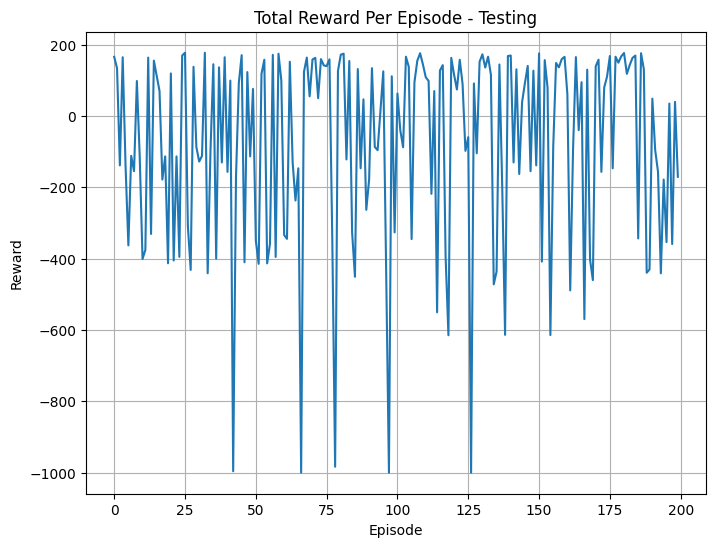

In [ ]:
dqn.test() #testing